# Dynamic Nelson-Siegel Model for Yield Curve

The written report for this project can be found [here](https://brianlim.xyz/files/Portfolio/Dynamic%20Nelson-Siegel%20Model.pdf).

## Import Libraries

The following libraries will be needed for this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import itertools
import datetime as dt
from dateutil.relativedelta import relativedelta
from IPython.display import display, clear_output
import statsmodels.api as sm
import statsmodels.tsa as tsa
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

## Data Processing

The functions below help convert from years (`int`) to labels (`str`) and vice versa. 

- 1.0 = 1Y
- 0.5 = 6M
- 1.5 = 1Y6M

In [2]:
# Convert years to labels
def to_string(y):
    if y == 0:
        return ''
    elif y < 1:
        return f'{int(12*y)}M'
    else:
        return f'{int(y)}Y' + to_string(y%1)

# Convert labels to years
def to_year(s):
    y = 0
    if 'Y' in s:
        y += int(s[:s.find('Y')])
        s = s[s.find('Y')+1:]
    if 'M' in s:
        y += int(s[:s.find('M')]) / 12
    return y

The function below returns the number of years (Actual/360) from `date` to `years` years from `date`. An optional argument `years_prev` returns the number of years between `years_prev` years from `date` and `year` years from `date`.

In [3]:
# Actual / 360 day count convention
def maturity(date, years, years_prev=0):
    return ( (date + relativedelta(months=int(12*years))) - (date + relativedelta(months=int(12*years_prev))) ).days / 360

The function below performs bootstraping to obtain zero rates.

In [4]:
# Performs bootstrapping to obtain zero rates
def bootstrap(df, dt=0.5):
    interp = {}
    discount = {}
    zero_rate = {}
    date = df['Date']

    # Input given tenors
    for t in df.index.drop('Date'):
        interp[to_year(t)] = df[t]
    
    # Max maturity
    N = max(interp.keys()) + dt

    for t in np.arange(dt,N,dt):
        # Interpolated Rates
        if t not in interp:
            for T in np.arange(t,N,dt):
                if T in interp: 
                    break
            interp[t] = np.interp(maturity(date, t), [maturity(date, t-dt), maturity(date, T)], [interp[t-dt], interp[T]])

        # Discount Factor
        if t <= 1:
            discount[t] = 1 / (1 + interp[t] / 100 * maturity(date, t))
        else:
            discount[t] = 1
            for tt in np.arange(dt,t,dt):
                discount[t] -= interp[t] / 100 * discount[tt] * maturity(date, tt, tt-dt)
            discount[t] /= (1 + interp[t] / 100 * maturity(date, t, t-dt))
            
        # Zero-Rate
        zero_rate[t] = - 100 * np.log(discount[t]) / maturity(date, t)
        
        # Modify entry
        if to_string(t) in df.index:
            df[to_string(t)] = zero_rate[t]
      
    # Convert the rest of the tenors to continuous
    for t in df.index.drop('Date'):
        if to_year(t) < dt:
            df[t] = 100 * np.log(1 + df[t] / 100 * maturity(date, to_year(t))) / maturity(date, to_year(t))

    return df

The data used is the PDST-R2 rates. The data is first cleaned and the zero rates are obtained using bootstraping. The data is also filtered to remove `NAN`s.

In [5]:
# Read csv
df = pd.read_csv('PDST-R2.csv')

# Clean data
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Compute continuously compounded short rate and bootstrap zero-rates
df = df.apply(lambda df: bootstrap(df), axis=1)

# Filter data for NANs
df = df[df['Date'] > max(df[df['20Y'].isna()]['Date'])].reset_index(drop=True)

df

,Date,1M,3M,6M,1Y,2Y,3Y,4Y,5Y,7Y,10Y,20Y
0,2009-01-13,5.123183,4.771527,4.955549,5.236024,5.439707,5.662898,5.862777,6.066751,6.930326,7.398710,21.338299
1,2009-01-14,5.031783,5.092446,4.988320,5.221893,5.544320,5.658562,5.820361,6.225506,6.882649,7.392790,21.275495
2,2009-01-15,4.638325,5.092446,4.898188,5.017959,5.538525,5.586187,5.901768,5.981654,6.996734,7.396800,24.089936
3,2009-01-16,5.039051,5.018388,4.923456,5.067557,5.489055,5.542985,5.958266,6.283226,7.035581,7.467916,22.458740
4,2009-01-19,5.088834,4.745143,5.019720,5.067557,5.332367,5.675831,6.037567,6.064725,6.984122,7.728880,24.910856
...,...,...,...,...,...,...,...,...,...,...,...,...
1814,2016-06-24,1.640578,1.840465,1.815200,1.767075,3.156413,3.308642,3.706014,2.913358,3.520295,4.603481,4.167066
1815,2016-06-27,1.633887,1.752769,1.537079,1.711366,2.467883,3.315442,3.707821,2.876520,3.008860,4.655114,4.390709
1816,2016-06-28,1.643874,1.747791,1.539758,1.806063,2.375316,3.079421,3.253144,2.780246,2.867855,4.243606,4.320919
1817,2016-06-29,1.647169,1.856987,1.800139,1.733182,2.336395,3.238439,3.424770,2.732893,2.896132,4.577629,4.323669


Afterwards, the zero rates every Wednesday is selected. 

In [6]:
# Get weekly dataframe
actual_df = df.copy()

# Get Wednesday entries or next available data if not trading day
actual_df = actual_df.groupby(pd.Grouper(key='Date', freq='W-TUE')).first()
actual_df = actual_df.reset_index()
actual_df['Date'] = actual_df['Date'] - pd.DateOffset(days=6)
actual_df = actual_df.set_index('Date')

# Manual filtering for edge cases (Week of Jan 13, 2009)
actual_df = actual_df.loc[dt.datetime(2009,1,14):,:]

actual_df

,1M,3M,6M,1Y,2Y,3Y,4Y,5Y,7Y,10Y,20Y
Date,,,,,,,,,,,
2009-01-14,5.031783,5.092446,4.988320,5.221893,5.544320,5.658562,5.820361,6.225506,6.882649,7.392790,21.275495
2009-01-21,4.526865,4.536280,4.820314,4.948746,5.247060,5.653470,5.909613,6.034512,7.119826,7.583523,27.466031
2009-01-28,4.590913,4.212837,4.506166,4.710693,5.448368,5.743342,6.011463,6.275037,6.969339,7.577937,27.270342
2009-02-04,4.492143,4.185966,4.449849,4.597083,5.426409,5.807038,6.173183,6.325992,7.139763,7.884033,18.004298
2009-02-11,4.492143,4.475153,4.816214,4.853594,5.367041,5.854646,6.167085,6.354719,7.234606,8.071675,17.194652
...,...,...,...,...,...,...,...,...,...,...,...
2016-06-01,1.645571,1.718720,2.463214,2.067479,3.030149,3.438248,3.542744,2.993567,3.355044,4.603319,4.516953
2016-06-08,1.638880,1.837280,1.593528,1.901943,2.997226,3.433233,3.465465,2.912827,3.216087,4.628993,5.124336
2016-06-15,1.642176,1.579807,1.576566,1.859658,2.396438,3.330897,3.578976,2.908837,3.143580,4.635413,5.374282


The data is then split into in-sample and out-of-sample.

In [7]:
# Get filter out-of-sample data
out_sample = actual_df.index.max() - relativedelta(years=1)
steps = actual_df.loc[out_sample:,:].shape[0]

print(f'Cut-off date: {out_sample}')
print(f'Number of data: {steps}')

Cut-off date: 2015-06-29 00:00:00
Number of data: 53


## Grid Search for $\lambda_t$ (Fixed Lambda Method)

The Nelson-Siegel model for yield is
$$y_t(\tau) = \beta_{0t} + \beta_{1t} \left( \frac{1-e^{-\tau/\lambda_t}}{\tau / \lambda_t} \right) + \beta_{2t} \left( \frac{1- e^{-\tau/\lambda_t}}{\tau/\lambda_t} - e^{-\tau/\lambda_t} \right),$$
where $\lambda_t$ is the shape parameter. For each $t$, when $\lambda_t$ is specified, the model becomes linear in the parameters $\beta_{0t}$, $\beta_{1t}$, and $\beta_{2t}$. Mathematically,
$$Y_\tau^t = \beta_{0t} + \beta_{1t} X_{1\tau}^t + \beta_{2t} X_{2\tau}^t,$$
where $Y_\tau^t = y_t(\tau)$, $X_{1\tau}^t = \dfrac{1 - e^\tau/ \lambda_t}{\tau / \lambda_t} $ and $X_{2\tau}^t = \dfrac{1 - e^\tau/ \lambda_t}{\tau / \lambda_t} - e^{-\tau/\lambda_t}$, with specific values of $\tau$ giving specific values of $Y_\tau^t$, $X_{1\tau}^t$, and $X_{2\tau}^t$.

Several methods can be used to obtain the value(s) of $\lambda_t$. One method is the fixed lambda method which considers the same value of $\lambda_t$ for all $t$ [(De Lara-Tuprio, et.al., 2017)](https://ejournals.ph/article.php?id=11592). Thus, a series of estimates $\{\beta_{0t}\}$, $\{\beta_{1t}\}$, $\{\beta_{2t}\}$ is obtained based on a single value of $\lambda_t$. In this method, a grid search is performed for $\lambda_t$ values ranging from 2 to 40 in small increments. For each value of $\lambda_t$, the average $R^2$ across all $t$ is calculated. Finally, the value of $\lambda_t$ that produced the highest $R^2$ is chosen.

In [8]:
# Summary dataframe of Rsquared
grid_df = pd.DataFrame()

# Iterate through possible values of lambda_t
dx = 0.001
for lambda_t in np.arange(2,40+dx,dx):
    Rsquared = []
    
    # Clean dataframe
    reg_df = pd.melt(actual_df.reset_index(), id_vars=['Date']).rename({'variable': 't', 'value': 'y'}, axis=1)
    reg_df['t'] = reg_df.apply(lambda df: maturity(df['Date'], to_year(df['t'])), axis=1)
    reg_df['X0'] = 1
    reg_df['X1'] = (1 - np.exp(- reg_df['t'] / lambda_t)) / (reg_df['t'] / lambda_t)
    reg_df['X2'] = (1 - np.exp(- reg_df['t'] / lambda_t)) / (reg_df['t'] / lambda_t) - np.exp(- reg_df['t'] / lambda_t)
    reg_df = reg_df.reset_index(drop=True)

    # Iterate through all dates
    for date, date_df in reg_df.groupby('Date'):
        # Skip out-of-sample
        if date > out_sample:
            continue

        # Perform linear regression to obtain Rsquared
        model = sm.OLS(endog=date_df['y'], exog=date_df[['X0', 'X1', 'X2']]).fit()

        # Append results
        Rsquared.append(model.rsquared)
    
    # Append final results
    grid_df = grid_df.append(
        pd.DataFrame([[lambda_t, date, np.mean(Rsquared)]], columns=['lambda_t', 'Date', 'Rsquared'])
    ).reset_index(drop=True)

# Get mean Rsquared per lambda_t
grid_dff = grid_df.groupby('lambda_t')[['Rsquared']].mean().reset_index()

grid_dff.sort_values('Rsquared', ascending=False).head(10)

,lambda_t,Rsquared
3434,5.434,0.964466
3435,5.435,0.964466
3433,5.433,0.964466
3436,5.436,0.964466
3432,5.432,0.964466
3431,5.431,0.964466
3437,5.437,0.964466
3438,5.438,0.964466
3430,5.430,0.964466
3439,5.439,0.964466


## Time Series Modelling for $\beta_{0,t}, \beta_{1,t}, \beta_{2,t}$

After obtaining the optimal value for $\lambda_t$, the time series of $\beta_{0,t}, \beta_{1,t}, \beta_{2,t}$ are obtained following the formula above.

In [9]:
# Get optimal lambda_t
lambda_t = grid_dff[grid_dff['Rsquared'] == grid_dff['Rsquared'].max()]['lambda_t'].iloc[0]

# Time series of betas
beta_df = pd.DataFrame()

# Clean dataframe
reg_df = pd.melt(actual_df.reset_index(), id_vars=['Date']).rename({'variable': 't', 'value': 'y'}, axis=1)
reg_df['t'] = reg_df.apply(lambda df: maturity(df['Date'], to_year(df['t'])), axis=1)
reg_df['X0'] = 1
reg_df['X1'] = (1 - np.exp(- reg_df['t'] / lambda_t)) / (reg_df['t'] / lambda_t)
reg_df['X2'] = (1 - np.exp(- reg_df['t'] / lambda_t)) / (reg_df['t'] / lambda_t) - np.exp(- reg_df['t'] / lambda_t)
reg_df = reg_df.reset_index(drop=True)

# Iterate through all dates
for date, date_df in reg_df.groupby('Date'):
    # Fill NANs for out-of-sample
    if date > out_sample:
        beta_df = beta_df.append(
            pd.DataFrame([[date]], columns=['Date'])
        ).reset_index(drop=True)
        continue

    # Perform linear regression to obtain betas
    model = sm.OLS(endog=date_df['y'], exog=date_df[['X0', 'X1', 'X2']]).fit()

    # Append betas
    beta_df = beta_df.append(
        pd.DataFrame([[date, model.params['X0'], model.params['X1'], model.params['X2'], model.rsquared]], 
                        columns=['Date', 'beta_0', 'beta_1', 'beta_2', 'Rsquared'])
    ).reset_index(drop=True)

# Set date as index and resample to W-WED
beta_df = beta_df.set_index('Date')
beta_df.index = pd.DatetimeIndex(beta_df.index, freq='W-WED')

display(beta_df.describe())
beta_df

,beta_0,beta_1,beta_2,Rsquared
count,337.000000,337.000000,337.000000,337.000000
mean,9.788597,-7.683124,-1.154726,0.964466
std,6.205514,5.211242,8.405596,0.032677
min,1.390245,-48.813521,-69.032021,0.783727
25%,5.942219,-10.196000,-4.222102,0.953760
50%,7.265732,-5.852238,0.687977,0.970870
75%,13.691549,-4.740994,3.539957,0.986928
max,54.749518,-1.176916,11.154890,0.999479


,beta_0,beta_1,beta_2,Rsquared
Date,,,,
2009-01-14,40.704933,-34.771275,-48.813832,0.932069
2009-01-21,54.749518,-48.813521,-69.032021,0.923358
2009-01-28,53.812420,-48.074963,-66.916967,0.918596
2009-02-04,31.791601,-26.902809,-32.246760,0.947337
2009-02-11,30.081440,-25.056686,-29.856050,0.957936
...,...,...,...,...
2016-06-01,NaN,NaN,NaN,NaN
2016-06-08,NaN,NaN,NaN,NaN
2016-06-15,NaN,NaN,NaN,NaN


The function below plots the ACF and PACF for a series and differenced series.

In [10]:
def acf_pacf(beta_df, series):
    # Plot beta time series
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,10))
    ax[0].plot(beta_df[series].dropna())
    ax[0].set_title(f'$\\{series}$ plot')
    tsaplots.plot_acf(beta_df[series].dropna(), ax[1])
    ax[1].set_title(f'$\\{series}$ ACF')
    tsaplots.plot_pacf(beta_df[series].dropna(), ax[2])
    ax[2].set_title(f'$\\{series}$ PACF')
    fig.show()

    # Plot differenced beta time series
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,10))
    ax[0].plot(beta_df[series].diff().dropna())
    ax[0].set_title(f'$d\\{series}$ plot')
    tsaplots.plot_acf(beta_df[series].diff().dropna(), ax[1])
    ax[1].set_title(f'$d\\{series}$ ACF')
    tsaplots.plot_pacf(beta_df[series].diff().dropna(), ax[2])
    ax[2].set_title(f'$d\\{series}$ PACF')
    fig.show()

In forecasting the yield curve under the Dynamic Nelson-Siegel model, consider the following. Suppose a series of estimates $\{\beta_{0t}\}$, $\{\beta_{1t}\}$, $\{\beta_{2t}\}$ is obtained using a single value of $\lambda_t$ (fixed lambda method). For each $\beta_{it}$, $i = 0, 1, 2$, several time series models are fitted. The ARIMA models are considered for the mean equation while Exponential GARCH models are considered for the variance equation. Mathematically, an ARIMA($p,d,q$)-EGARCH($m,s$) model is given by
$$(1-B)^d X_t = \phi_0 + \sum_{i=1}^p \phi_i (1-B)^d X_{t-i} + a_t - \sum_{i=1}^q \theta_i a_{t-i},$$
$$a_t = \sigma_t \epsilon_t,$$
$$\ln(\sigma_t^2) = \alpha_0 + \sum_{i=1}^m \alpha_i\dfrac{|a_{t-i}| + \gamma_i a_{t-i}}{\sigma_{t-i}} + \sum_{i=1}^s \beta_i \ln(\sigma_{t-i}^2),$$
where $B$ is the back-shift operator, $\phi_i$ is the coefficient of the autoregressive (AR) component, $\theta_i$ is the coefficient of the moving average (MA) component, $a_t$ is the error term at time $t$, $\sigma_t$ is the standard deviation at time $t$, $\epsilon_t \sim (0,1)$ is a white noise series, $\alpha_i$ is the coefficient of the moving average (MA) component of the residual of the log variance, $\gamma_i$ is the leverage effect of $a_t$, $i$ periods ago, and $\beta_i$ is the coefficient of the autoregressive (AR) component of the residual of the log variance. 

The function below explores the best time series models for the betas using AIC as the criteria.

In [11]:
def fit_betas(beta_df, series, max_beta_orders, steps):
    beta_df = beta_df.copy()

    # Generate possible ARIMA orders
    arima_orders = [
        [i for i in range(max_beta_orders[0][0]+1)],
        [i for i in range(max_beta_orders[0][1]+1)],
        [i for i in range(max_beta_orders[0][2]+1)]
    ]
    
    # Iterate through all possible orders
    best_aic = 1e100
    arima_df = pd.DataFrame()
    for arima_order in itertools.product(*arima_orders):
        # Fit model
        curr_arima_model = tsa.arima.model.ARIMA(beta_df[series].dropna(), order=arima_order).fit()
        arima_df = arima_df.append(
            pd.DataFrame([[arima_order, curr_arima_model.aic, curr_arima_model.bic, curr_arima_model.hqic]], 
                        columns=['ARIMA Order', 'AIC', 'BIC', 'HQIC'])
        ).reset_index(drop=True)

        # Update best model
        if best_aic > curr_arima_model.aic:
            best_aic = curr_arima_model.aic
            arima_model = curr_arima_model
            best_arima_order = arima_order
    
    # Generate possible EGARCH orders
    garch_orders = [
        [i for i in range(1, max_beta_orders[1][0]+1)],
        [i for i in range(1, max_beta_orders[1][1]+1)],
        ['t', 'normal', 'ged'],
        ['GARCH', 'EGARCH']
    ]

    # Iterate through all possible orders
    best_aic = 1e100
    garch_df = pd.DataFrame()
    for garch_order in itertools.product(*garch_orders):
        # Fit model
        curr_garch_model = arch_model(arima_model.resid, vol=garch_order[3], p=garch_order[0], q=garch_order[1],
                                     dist=garch_order[2]).fit(disp='off')
        garch_df = garch_df.append(
            pd.DataFrame([[best_arima_order, garch_order[3], garch_order[:2], garch_order[2], curr_garch_model.aic, curr_garch_model.bic]],
                        columns=['ARIMA Order', 'GARCH Type', 'GARCH Order', 'Distribution', 'AIC', 'BIC'])
        ).reset_index(drop=True)

        # Update best model
        if best_aic > curr_garch_model.aic:
            best_aic = curr_garch_model.aic
            garch_model = curr_garch_model
            best_garch_order = garch_order
    
    # Print results
    print(f'{series} Summary')
    print(f'ARIMA{best_arima_order} - {best_garch_order[3]}{best_garch_order[:2]}')
    print(f'Distribution: {best_garch_order[2]}')
    print('======================================')

    # KPSS Test for stationarity
    kpss = tsa.stattools.kpss(beta_df[series].dropna())
    print(f'KPSS Test Results')
    print(f'KPSS\t {kpss[0]}')
    print(f'p-value\t {kpss[1]}\n')
    
    # ARCH LM for ARCH effect
    lm = het_arch(arima_model.resid)
    print('ARCH LM Test Results')
    print(f'LM\t{lm[0]}')
    print(f'p-value\t{lm[1]}\n')

    # Print possible models
    display(arima_df.sort_values('AIC').head())
    display(garch_df.sort_values('AIC').head())

    # Forecast betas
    arima_pred = arima_model.forecast(steps=steps)
    egarch_pred = garch_model.forecast(horizon=steps, reindex=False, method='simulation').mean.values
    beta_df.loc[out_sample:,series] = np.array(arima_pred) + np.array(egarch_pred)

    return beta_df

### $\beta_{0,t}$ Parameters

This subsection explores the optimal ARIMA-EGARCH parameters for $\beta_{0,t}$.

beta_0 Summary
ARIMA(2, 1, 2) - EGARCH(1, 1)
Distribution: t
KPSS Test Results
KPSS	 1.5509479574976737
p-value	 0.01

ARCH LM Test Results
LM	116.98570308428148
p-value	5.772305813203103e-17



,ARIMA Order,AIC,BIC,HQIC
23,"(2, 1, 2)",1324.163255,1343.248811,1331.771293
26,"(2, 2, 2)",1339.964772,1359.035425,1347.567684
22,"(2, 1, 1)",1341.690090,1356.958534,1347.776520
14,"(1, 1, 2)",1343.566561,1358.835006,1349.652991
25,"(2, 2, 1)",1343.630446,1358.886968,1349.712776


,ARIMA Order,GARCH Type,GARCH Order,Distribution,AIC,BIC
1,"(2, 1, 2)",EGARCH,"(1, 1)",t,873.389129,892.489543
0,"(2, 1, 2)",GARCH,"(1, 1)",t,874.239262,893.339677
13,"(2, 1, 2)",EGARCH,"(2, 1)",t,875.173911,898.094409
7,"(2, 1, 2)",EGARCH,"(1, 2)",t,875.295709,898.216206
6,"(2, 1, 2)",GARCH,"(1, 2)",t,876.092357,899.012854


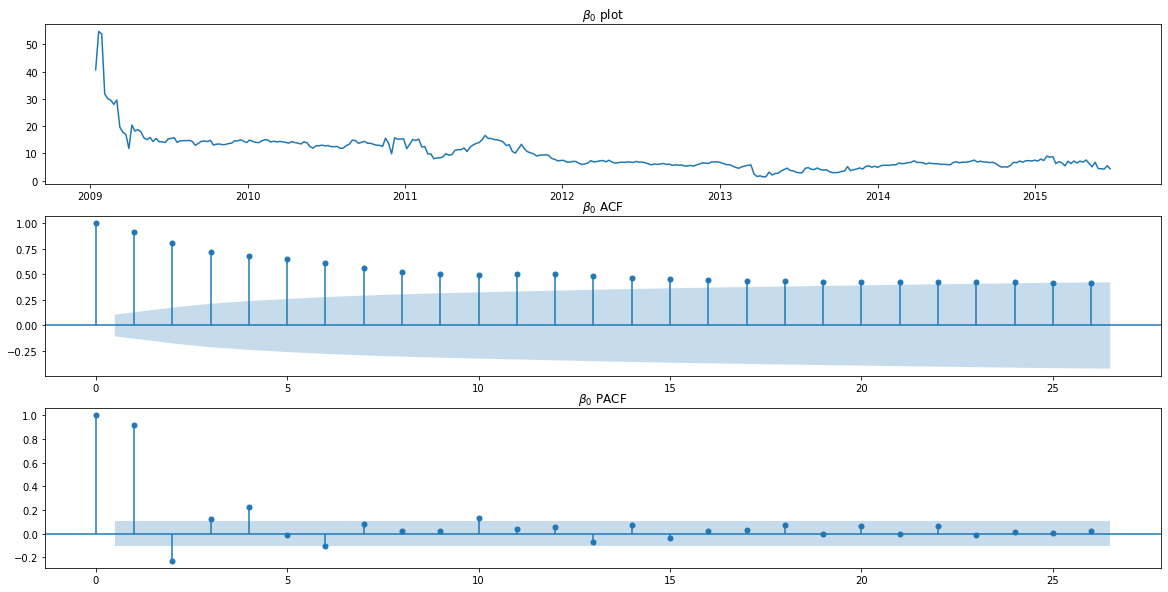

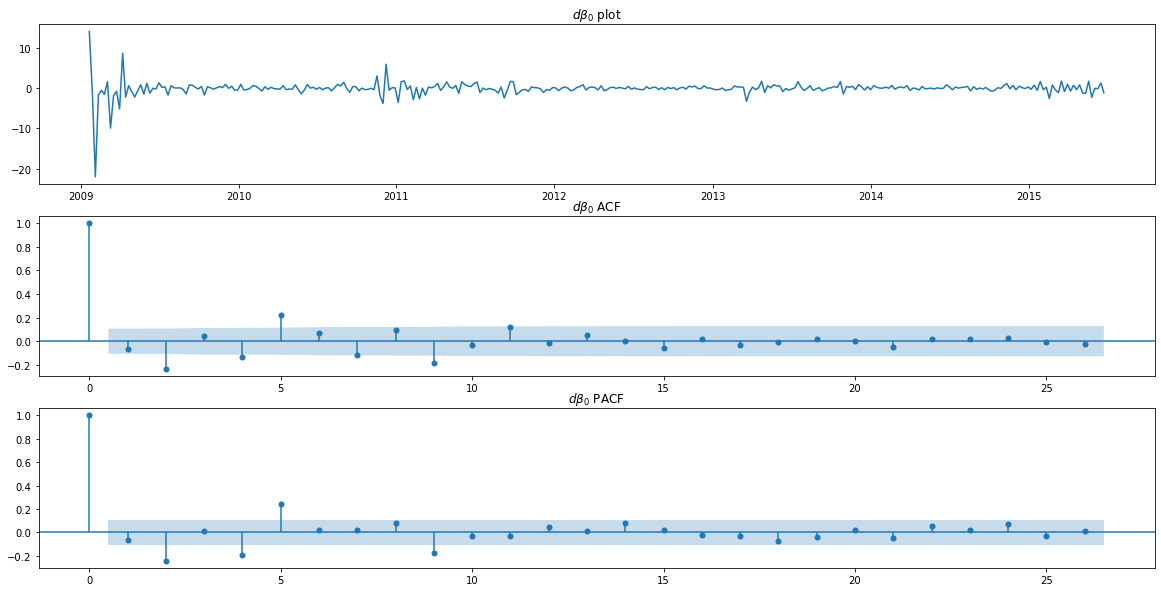

In [12]:
# Plot ACF and PACF
acf_pacf(beta_df, 'beta_0')

# Possible ARIMA-GARCH orders
beta_df = fit_betas(beta_df, 'beta_0', [(2,2,2), (2,2)], steps)

### $\beta_{1,t}$ Parameters

This subsection explores the optimal ARIMA-EGARCH parameters for $\beta_{1,t}$.

beta_1 Summary
ARIMA(2, 1, 2) - EGARCH(1, 1)
Distribution: t
KPSS Test Results
KPSS	 1.4453427810837762
p-value	 0.01

ARCH LM Test Results
LM	128.9062826493671
p-value	3.042662795548975e-19



,ARIMA Order,AIC,BIC,HQIC
23,"(2, 1, 2)",1281.638094,1300.723650,1289.246132
26,"(2, 2, 2)",1298.990081,1318.060734,1306.592994
22,"(2, 1, 1)",1301.249112,1316.517556,1307.335542
14,"(1, 1, 2)",1305.804345,1321.072789,1311.890775
25,"(2, 2, 1)",1307.968782,1323.225304,1314.051112


,ARIMA Order,GARCH Type,GARCH Order,Distribution,AIC,BIC
1,"(2, 1, 2)",EGARCH,"(1, 1)",t,820.177624,839.278039
0,"(2, 1, 2)",GARCH,"(1, 1)",t,821.482586,840.583001
13,"(2, 1, 2)",EGARCH,"(2, 1)",t,821.965047,844.885545
7,"(2, 1, 2)",EGARCH,"(1, 2)",t,822.022411,844.942908
6,"(2, 1, 2)",GARCH,"(1, 2)",t,822.043224,844.963722


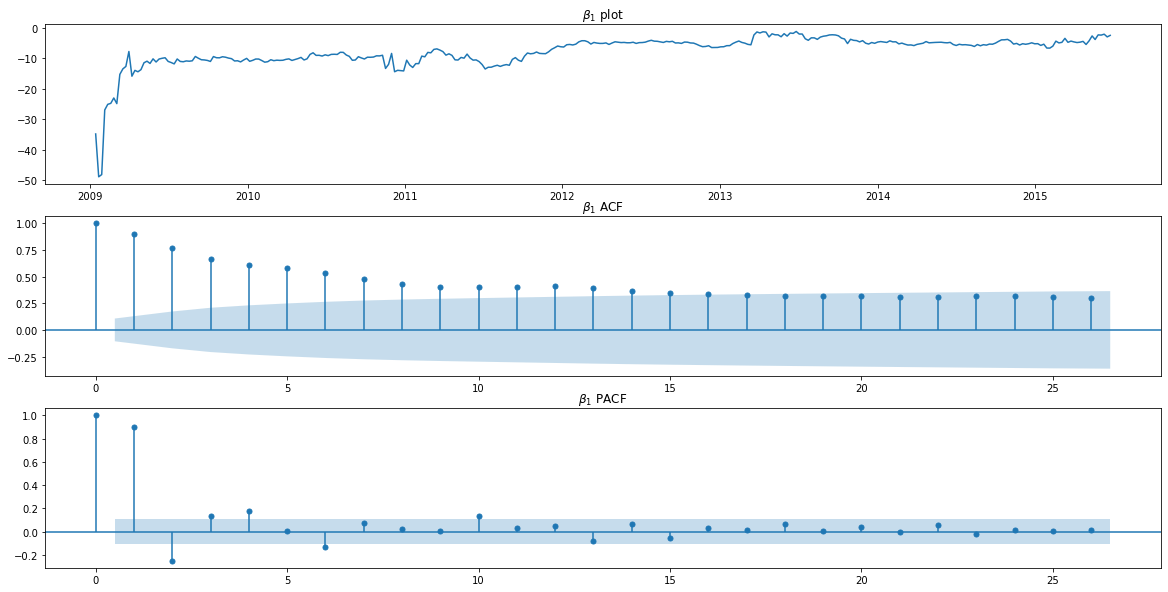

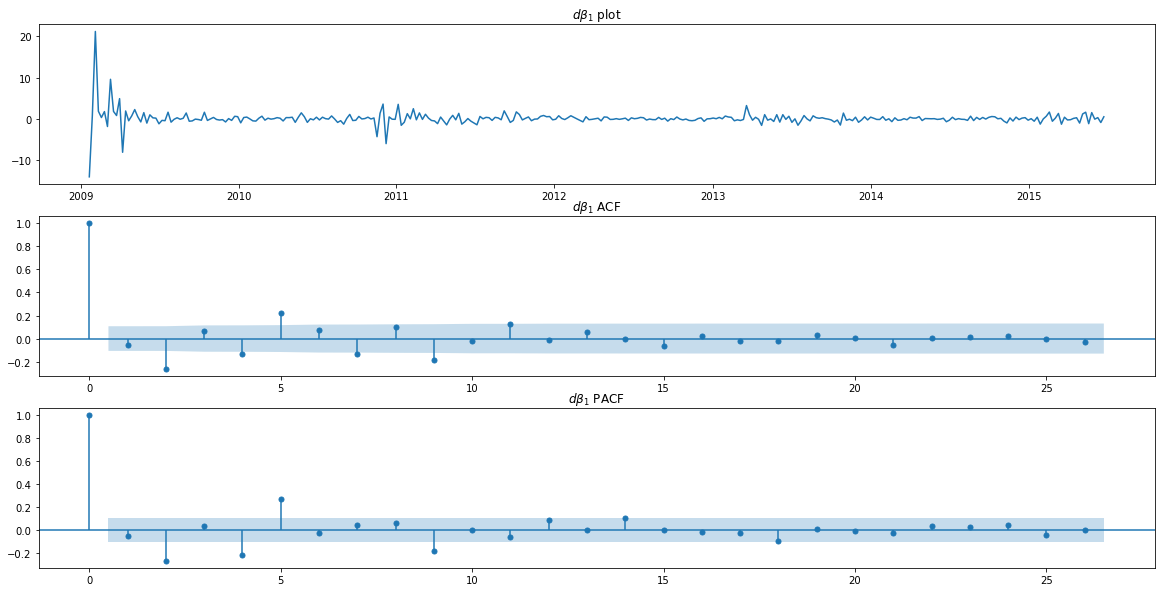

In [13]:
# Plot ACF and PACF
acf_pacf(beta_df, 'beta_1')

# Possible ARIMA-GARCH orders
beta_df = fit_betas(beta_df, 'beta_1', [(2,2,2), (2,2)], steps)

### $\beta_{2,t}$ Parameters

This subsection explores the optimal ARIMA-EGARCH parameters for $\beta_{2,t}$.

beta_2 Summary
ARIMA(0, 1, 2) - EGARCH(1, 1)
Distribution: t
KPSS Test Results
KPSS	 1.0243656602657416
p-value	 0.01

ARCH LM Test Results
LM	52.10906020120838
p-value	1.9760114016843375e-05



,ARIMA Order,AIC,BIC,HQIC
5,"(0, 1, 2)",1717.226841,1728.678175,1721.791664
21,"(2, 1, 0)",1717.696412,1729.147746,1722.261235
14,"(1, 1, 2)",1717.735782,1733.004227,1723.822212
25,"(2, 2, 1)",1718.137523,1733.394045,1724.219853
22,"(2, 1, 1)",1719.434511,1734.702956,1725.520941


,ARIMA Order,GARCH Type,GARCH Order,Distribution,AIC,BIC
1,"(0, 1, 2)",EGARCH,"(1, 1)",t,1330.957614,1350.058029
5,"(0, 1, 2)",EGARCH,"(1, 1)",ged,1331.024194,1350.124608
0,"(0, 1, 2)",GARCH,"(1, 1)",t,1331.670328,1350.770743
4,"(0, 1, 2)",GARCH,"(1, 1)",ged,1331.696157,1350.796572
13,"(0, 1, 2)",EGARCH,"(2, 1)",t,1332.548151,1355.468648


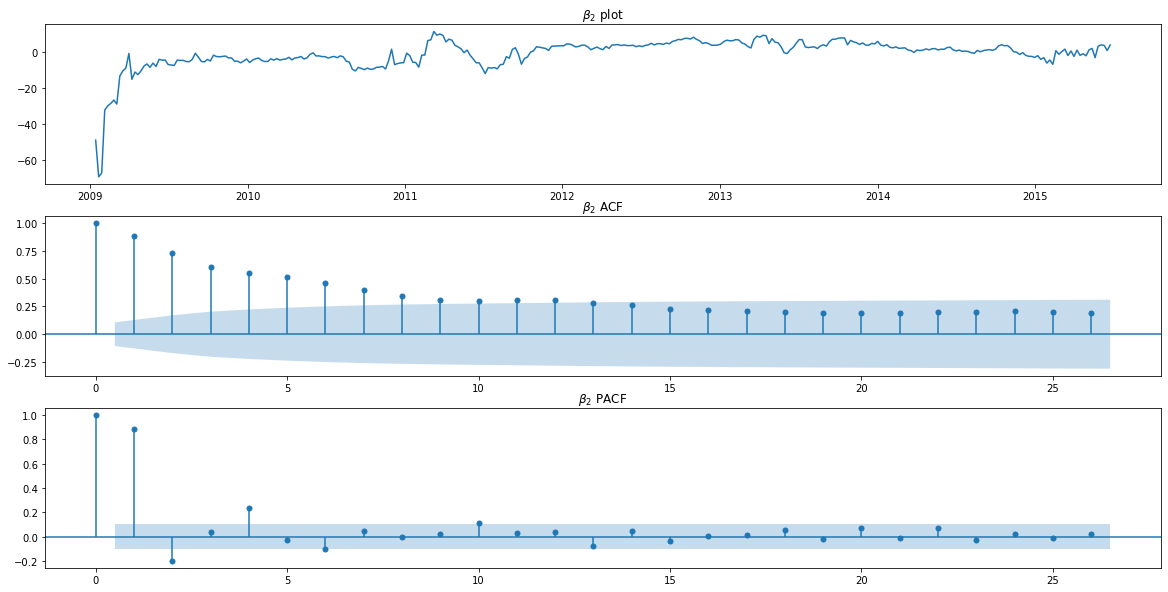

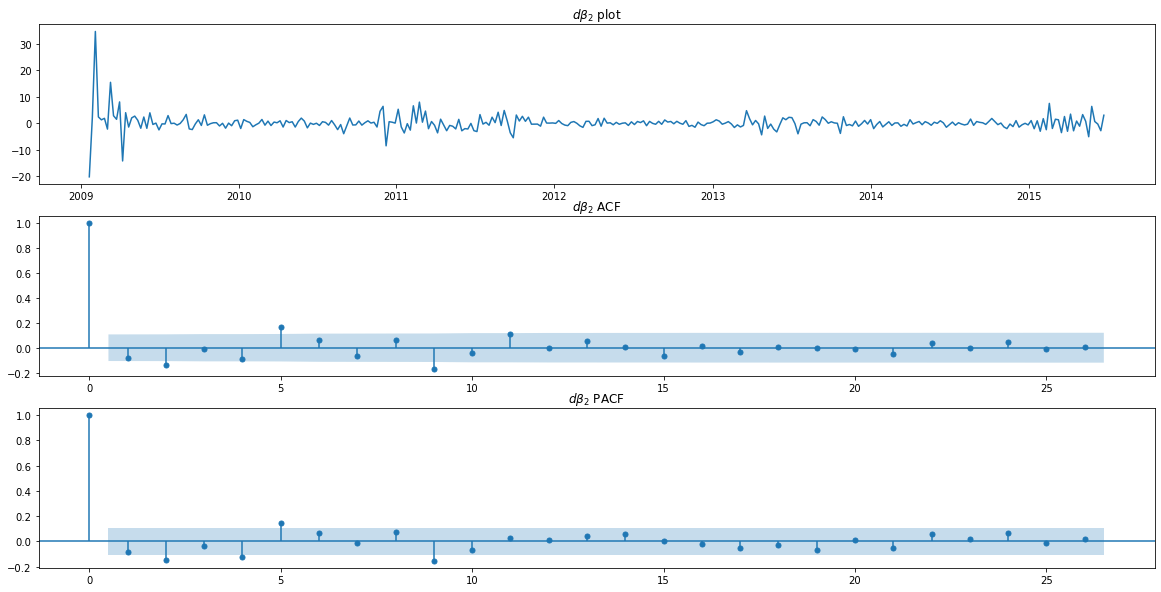

In [14]:
# Plot ACF and PACF
acf_pacf(beta_df, 'beta_2')

# Possible ARIMA-GARCH orders
beta_df = fit_betas(beta_df, 'beta_2', [(2,2,2), (2,2)], steps)

The final values for $\beta_{0,t}, \beta_{1,t}, \beta_{2,t}$ are shown below.

In [15]:
beta_df.iloc[-steps:,:].drop('Rsquared', axis=1)

,beta_0,beta_1,beta_2
Date,,,
2015-07-01,3.984355,-1.858490,3.841114
2015-07-08,4.176192,-2.172490,3.396511
2015-07-15,4.207674,-2.260570,3.396511
2015-07-22,3.981231,-1.851002,3.396511
2015-07-29,4.269482,-2.340504,3.396511
2015-08-05,4.079568,-2.033585,3.396511
2015-08-12,4.072611,-2.013342,3.396511
2015-08-19,4.262770,-2.322028,3.396511
2015-08-26,4.002204,-1.910924,3.396511


## Forecasting Yield Curve

After obtaining the time series models for $\beta_{0t}$, $\beta_{1t}$, $\beta_{2t}$, the $\ell$-step ahead forecasts are obtained using these models. Finally, using the $\ell$-step ahead forecasts $\beta_{0(t+\ell)}$, $\beta_{1(t+\ell)}$, and $\beta_{2(t+\ell)}$, the yield curve in $\ell$ periods is calculated as
$$y_{(t+\ell)}(\tau) = \beta_{0(t+\ell)} + \beta_{1(t+\ell)} \left( \frac{1-e^{-\tau/\lambda}}{\tau / \lambda} \right) + \beta_{2(t+\ell)} \left( \frac{1- e^{-\tau/\lambda}}{\tau/\lambda} - e^{-\tau/\lambda} \right),$$
where $\lambda$ is the value of $\lambda_t$ obtained using the fixed lambda method.

In [16]:
pred_df = actual_df.copy()
pred_df.index = pd.DatetimeIndex(pred_df.index, freq='W-WED')

for date in pred_df.index:
    if date <= out_sample:
        continue

    for col in actual_df.columns:
        t = to_year(col)
        pred_df.loc[date, col] = (
            beta_df.loc[date, 'beta_0'] +
            beta_df.loc[date, 'beta_1'] * (1 - np.exp(- maturity(date,t) / lambda_t)) / (maturity(date,t) / lambda_t) + 
            beta_df.loc[date, 'beta_2'] * ((1 - np.exp(- maturity(date,t) / lambda_t)) / (maturity(date,t) / lambda_t) - np.exp(- maturity(date,t) / lambda_t))
        )

pred_df

,1M,3M,6M,1Y,2Y,3Y,4Y,5Y,7Y,10Y,20Y
Date,,,,,,,,,,,
2009-01-14,5.031783,5.092446,4.988320,5.221893,5.544320,5.658562,5.820361,6.225506,6.882649,7.392790,21.275495
2009-01-21,4.526865,4.536280,4.820314,4.948746,5.247060,5.653470,5.909613,6.034512,7.119826,7.583523,27.466031
2009-01-28,4.590913,4.212837,4.506166,4.710693,5.448368,5.743342,6.011463,6.275037,6.969339,7.577937,27.270342
2009-02-04,4.492143,4.185966,4.449849,4.597083,5.426409,5.807038,6.173183,6.325992,7.139763,7.884033,18.004298
2009-02-11,4.492143,4.475153,4.816214,4.853594,5.367041,5.854646,6.167085,6.354719,7.234606,8.071675,17.194652
...,...,...,...,...,...,...,...,...,...,...,...
2016-06-01,2.039599,2.123635,2.241874,2.461184,2.839309,3.147309,3.398227,3.600974,3.896617,4.153274,4.346737
2016-06-08,2.072204,2.157148,2.276686,2.498476,2.881142,3.193168,3.447672,3.653602,3.954624,4.217439,4.422102
2016-06-15,2.065456,2.149479,2.267700,2.486975,2.865036,3.172979,3.423847,3.626549,3.922117,4.178687,4.371994


The functions below plot the yield curve (surface and cross section).

In [17]:
# Function to map values
def zero_rate(X,Y,df):
    Z = np.zeros(X.shape)
    for x in range(X.shape[0]):
        for y in range(X.shape[1]):
            Z[x][y] = df[df['Date'] == Y[x][y]][to_string(X[x][y])].iloc[0]
    return Z

# Function to plot surface
def plot_surf(df, tenors):
    # Meshgrid
    x = tenors
    y = df['Date']
    X, Y = np.meshgrid(x, y)
    Z = zero_rate(X,Y,df)

    # Change axes
    y = (df['Date'] - min(df['Date'])).dt.days
    X, Y = np.meshgrid(x, y)

    # Plot surface
    fig = plt.figure(figsize=(15, 15))
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_xlabel('Maturity')
    ax.set_ylabel('Date')
    fig.show()

# Function to plot cross section
def cross(pred_df, df, date):
    pred_df = pred_df[pred_df['Date'] == date][['Date'] + [to_string(t) for t in tenors]].set_index('Date')
    df = df[df['Date'] == date][['Date'] + [to_string(t) for t in tenors]].set_index('Date')
    
    pred_df.columns = [to_year(col) for col in pred_df.columns]
    pred_df.index = ['Predicted']
    df.columns = [to_year(col) for col in df.columns]
    df.index = ['Actual']

    cross_df = pd.merge(pred_df.T, df.T, how='outer', left_index=True, right_index=True)
    plt.figure(figsize=(10,5))
    plt.plot(cross_df)
    plt.xlabel('Maturity')
    plt.ylabel('Zero-Rate')
    plt.legend(('Forecasted', 'Actual'))

The forecasted yield curve, actual yield curve, and cross section are plotted below.

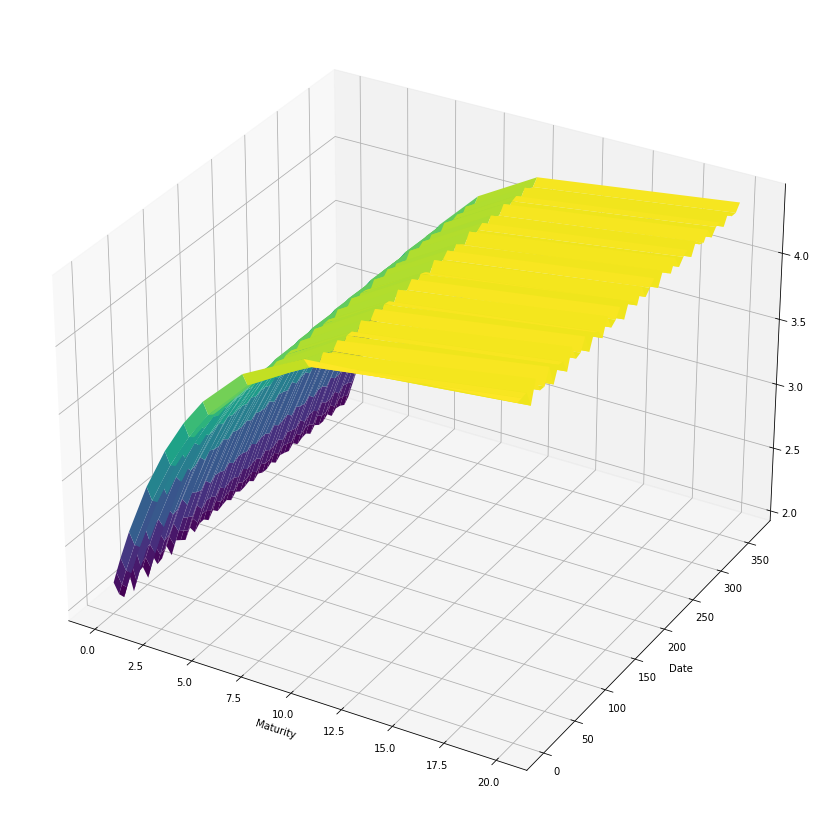

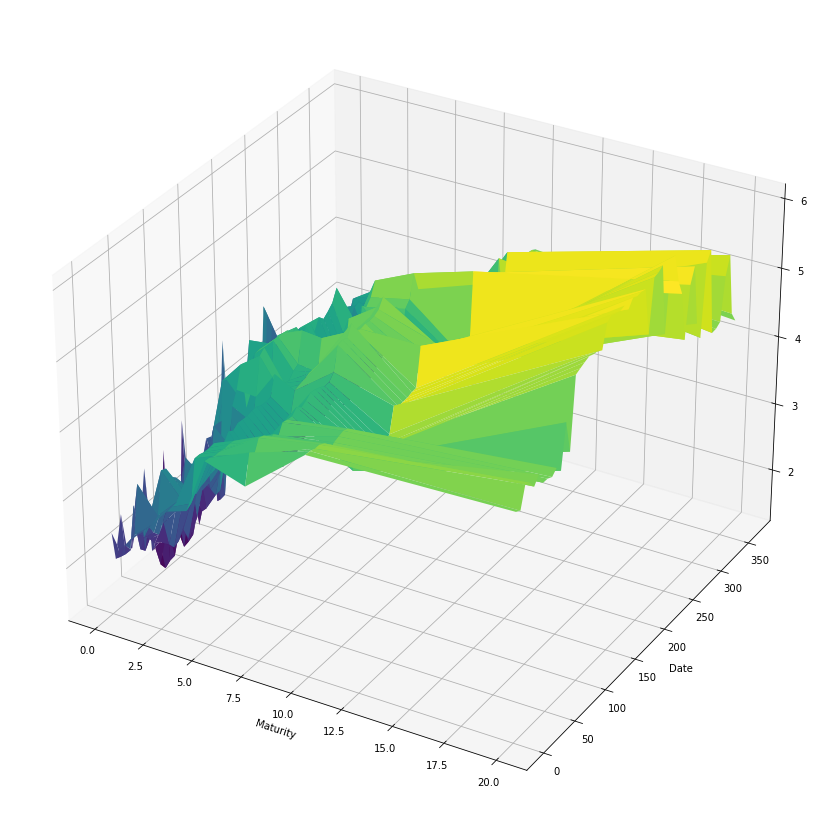

In [18]:
tenors = [to_year(t) for t in pred_df.columns]
actual = actual_df.loc[out_sample:,:].reset_index()
pred = pred_df.loc[out_sample:,:].reset_index()

# Forecasted yield curve
plot_surf(pred, tenors)
# Actual yield curve
plot_surf(actual, tenors)

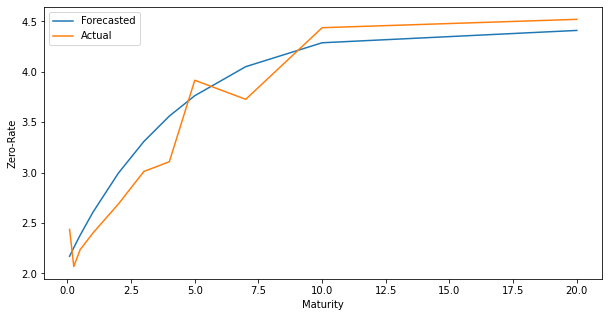

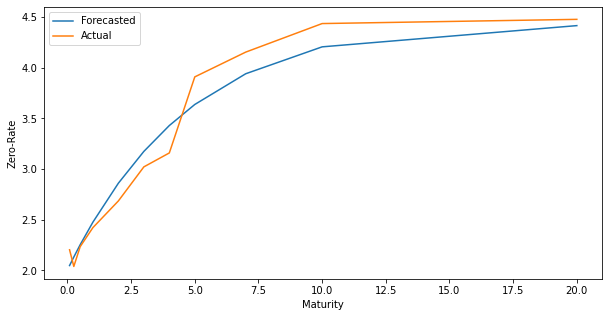

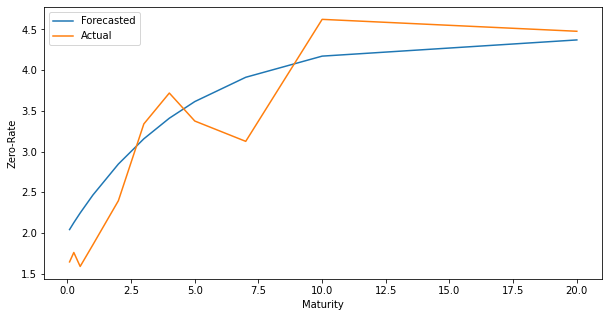

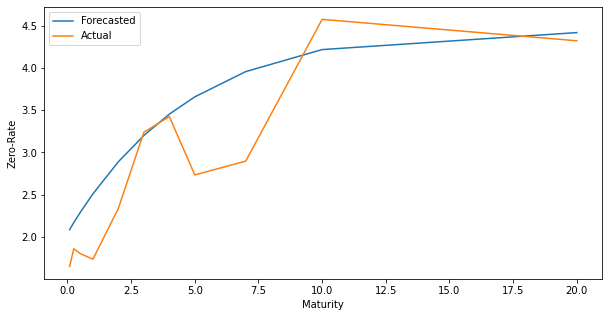

In [19]:
# Plot cross section July 1, 2015, July 8, 2015, June 22, 2016, and June 29, 2016
cross(pred, actual, dt.datetime(2015,7,1))
cross(pred, actual, dt.datetime(2015,7,8))
cross(pred, actual, dt.datetime(2016,6,22))
cross(pred, actual, dt.datetime(2016,6,29))

Lastly, the root mean squared error (RMSE) is obtained per date, per tenor, and overall. 

In [20]:
actual = pd.melt(actual_df.loc[out_sample:, :].reset_index(), id_vars='Date').set_index('Date')
pred = pd.melt(pred_df.loc[out_sample:, :].reset_index(), id_vars='Date').set_index('Date')

print(f"Overall RMSE: {round(mean_squared_error(actual['value'], pred['value'], squared=False),6)}")

rmse_df = pd.DataFrame()
for tenor in actual_df.columns:
    rmse_df = rmse_df.append(
        pd.DataFrame([[tenor, mean_squared_error(actual.loc[actual['variable'] == tenor, 'value'], 
                            pred.loc[pred['variable'] == tenor, 'value'], squared=False)]], columns=['Tenor', 'RMSE'])
    ).reset_index(drop=True)
display(rmse_df)

rmse_df = pd.DataFrame()
for date in actual_df.loc[out_sample:,:].index:
    rmse_df = rmse_df.append(
        pd.DataFrame([[date, mean_squared_error(actual.loc[date,'value'], pred.loc[date,'value'], squared=False)]], columns=['Date', 'RMSE'])
    ).reset_index(drop=True)
display(rmse_df)

Overall RMSE: 0.593478


,Tenor,RMSE
0,1M,0.625646
1,3M,0.509131
2,6M,0.495121
3,1Y,0.602862
4,2Y,0.549034
5,3Y,0.582999
6,4Y,0.336898
7,5Y,0.391189
8,7Y,0.539529
9,10Y,0.401889


,Date,RMSE
0,2015-07-01,0.255678
1,2015-07-08,0.175686
2,2015-07-15,0.340064
3,2015-07-22,0.304211
4,2015-07-29,0.245809
5,2015-08-05,0.238645
6,2015-08-12,0.260857
7,2015-08-19,0.354889
8,2015-08-26,0.368384
9,2015-09-02,0.384304
